In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [343]:
# Lendo o arquivo CSV e criando coluna de "Vencedor da Partida"
df = pd.read_csv('Data/campeonatos_futebol_atualizacao.csv')
df["Vencedor"] = df.apply(lambda x: x["Time 1"] if x["Gols 1"] > x["Gols 2"] else x["Time 2"] if x["Gols 1"] < x["Gols 2"] else "Empate", axis=1)
df["Vitória em Casa"] = df.apply(lambda x: 1 if x["Vencedor"] == x["Time 1"] else 0 if x["Vencedor"] == x["Time 2"] else np.nan, axis=1)

In [344]:
# Exibindo o dataset
df

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Defesas difíceis 1,Defesas difíceis 2,Posse 1(%),Posse 2(%),Time 1,Time 2,Position 1,Position 2,Vencedor,Vitória em Casa
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,NaN,NaN,77.0,23.0,Glasgow Rangers,Livingston,4-3-3,4-3-3,Glasgow Rangers,1.0
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,NaN,NaN,44.0,56.0,Ross County,St.Johnstone,3-5-2,3-5-2,Empate,NaN
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,NaN,NaN,47.0,53.0,Dundee FC,St. Mirren,4-3-3,3-4-1-2,Empate,NaN
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,NaN,NaN,27.0,73.0,Hearts,Celtic,3-4-3,4-2-3-1,Hearts,1.0
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,NaN,NaN,58.0,42.0,Aberdeen,Dundee U.,4-4-2,3-5-1-1,Aberdeen,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27711,6.0,2.0,1.0,0.0,9.0,6.0,6.0,5.0,7.0,7.0,...,NaN,NaN,52.0,48.0,Aston Villa,Blackburn,4-4-2,4-5-1,Blackburn,0.0
27712,6.0,0.0,4.0,3.0,4.0,2.0,8.0,2.0,11.0,9.0,...,NaN,NaN,52.0,48.0,Arsenal,Fulham,4-2-3-1,4-4-2,Arsenal,1.0
27713,7.0,7.0,2.0,3.0,10.0,2.0,8.0,0.0,10.0,6.0,...,NaN,NaN,55.0,45.0,Manchester Utd,Stoke,4-4-2,4-4-2,Manchester Utd,1.0
27714,6.0,6.0,1.0,2.0,4.0,3.0,4.0,6.0,5.0,3.0,...,NaN,NaN,45.0,55.0,West Ham,Manchester City,4-5-1,4-4-2,Empate,NaN


In [345]:
# Definindo o estilo para combinar com o fundo branco que é o padrão
sns.set_style("white")

# Análise Exploratória de Dados

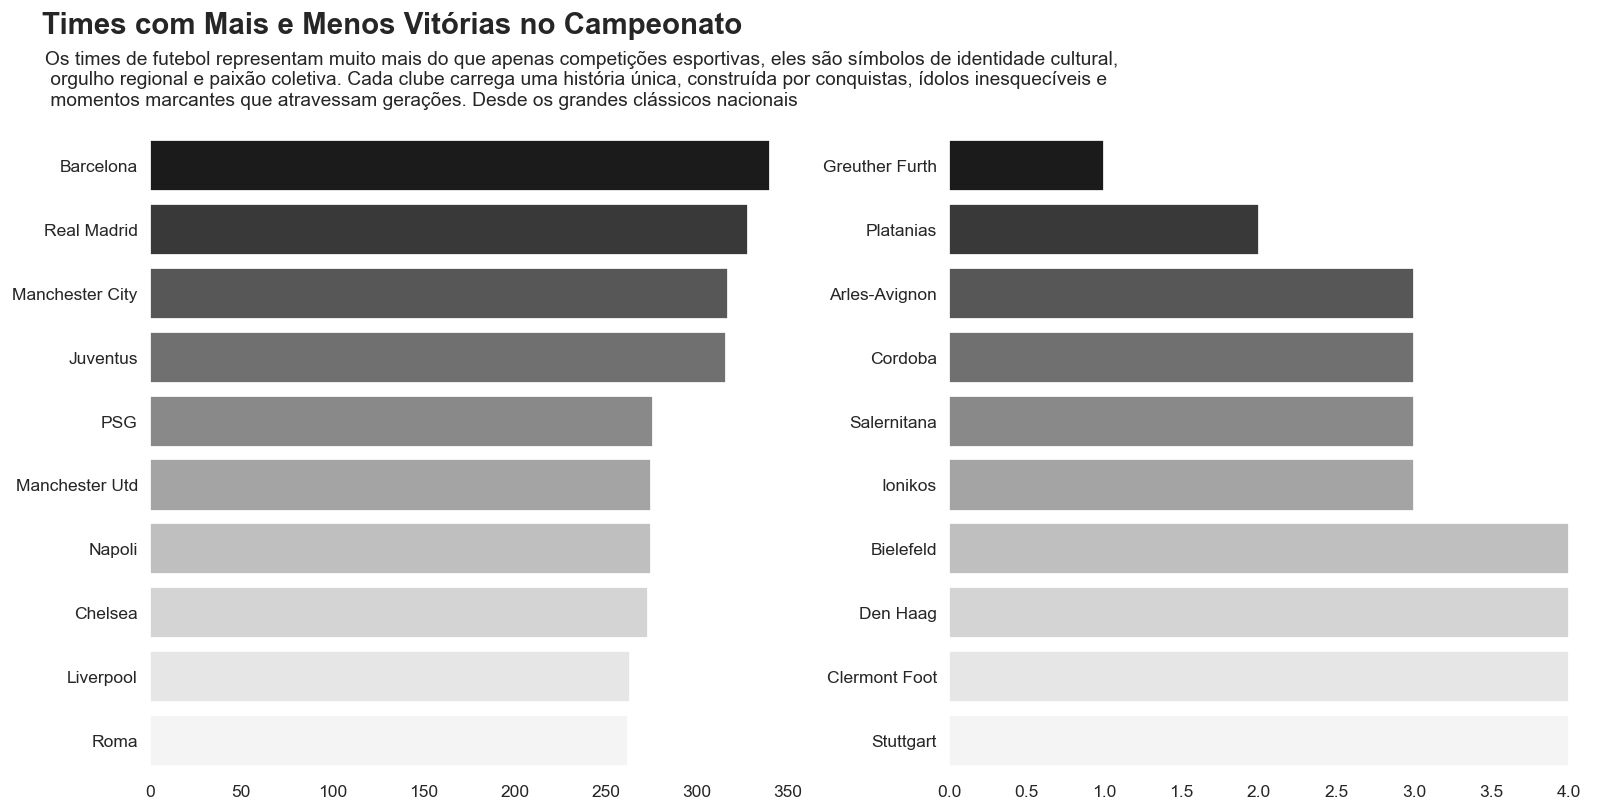

In [346]:
# Criação dos subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=125)

for idx, bool in enumerate([False, True]):
    aux_top = df[df["Vencedor"] != "Empate"]["Vencedor"].value_counts(ascending = bool).head(10).reset_index()
    aux_top.columns = ["Vencedores", "Contagem"]
    sns.barplot(data=aux_top, y="Vencedores", x="Contagem", hue="Vencedores", legend=False, palette='Greys_r', ax=axs[idx])
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    for spine in axs[idx].spines.values(): spine.set_visible(False)

# Título principal
fig.suptitle('Times com Mais e Menos Vitórias no Campeonato', x=0.03, ha="left", fontsize=17, fontweight='bold', y=1.075)
fig.text(0.0315, 0.95, 'Os times de futebol representam muito mais do que apenas competições esportivas, eles são símbolos de identidade cultural,\n orgulho regional e paixão coletiva. Cada clube carrega uma história única, construída por conquistas, ídolos inesquecíveis e \n momentos marcantes que atravessam gerações. Desde os grandes clássicos nacionais', fontsize=11)
plt.tight_layout()
plt.show()

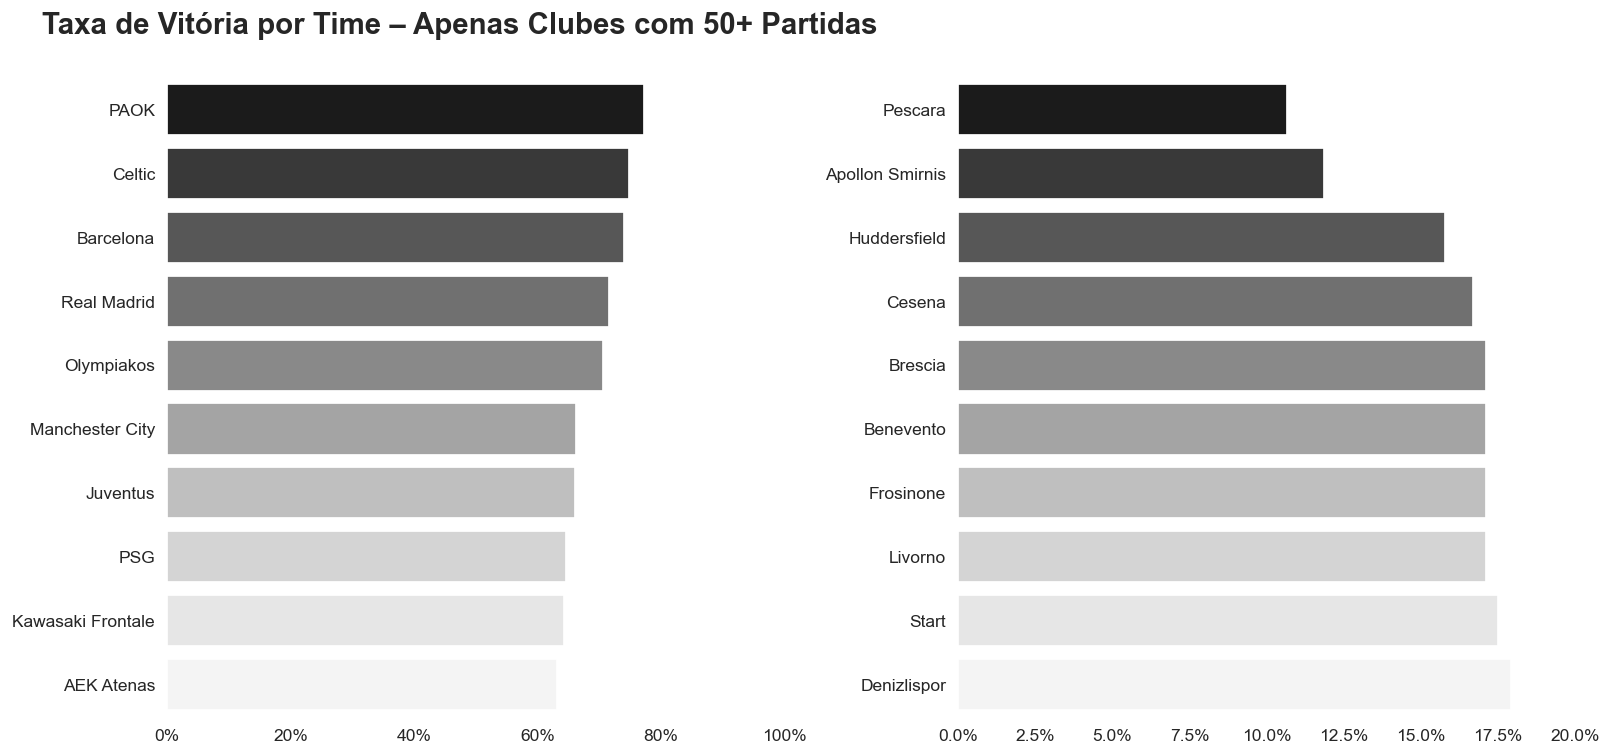

In [347]:
# Calculando a taxa de vitórias por time com pelo menos mais de 50 jogos
vitorias = df[df["Vencedor"] != "Empate"]["Vencedor"].value_counts()
jogos = pd.concat([df["Time 1"], df["Time 2"]]).value_counts()
proporcao = (vitorias / jogos[jogos > 50]).dropna().sort_values(ascending=False)
proporcao = (proporcao * 100).round(2)

# Criando subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=125)

# Loop para Top e Bottom 10
for idx, ascending in enumerate([False, True]):
    aux = proporcao.sort_values(ascending=ascending).head(10).reset_index()
    aux.columns = ["Time", "Taxa de Vitória"]
    bars = sns.barplot(data=aux, y="Time", x="Taxa de Vitória", hue="Time", legend=False, palette='Greys_r', ax=axs[idx])
    
    # Estilização dos gráficos
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].set_xlim(0, 100) if idx == 0 else axs[idx].set_xlim(0, 20)
    for spine in axs[idx].spines.values(): spine.set_visible(False)
    axs[idx].xaxis.set_major_formatter(PercentFormatter(xmax=100))

fig.suptitle('Taxa de Vitória por Time – Apenas Clubes com 50+ Partidas',x=0.03, ha="left", fontsize=17, fontweight='bold', y=1)
plt.tight_layout()
plt.show()


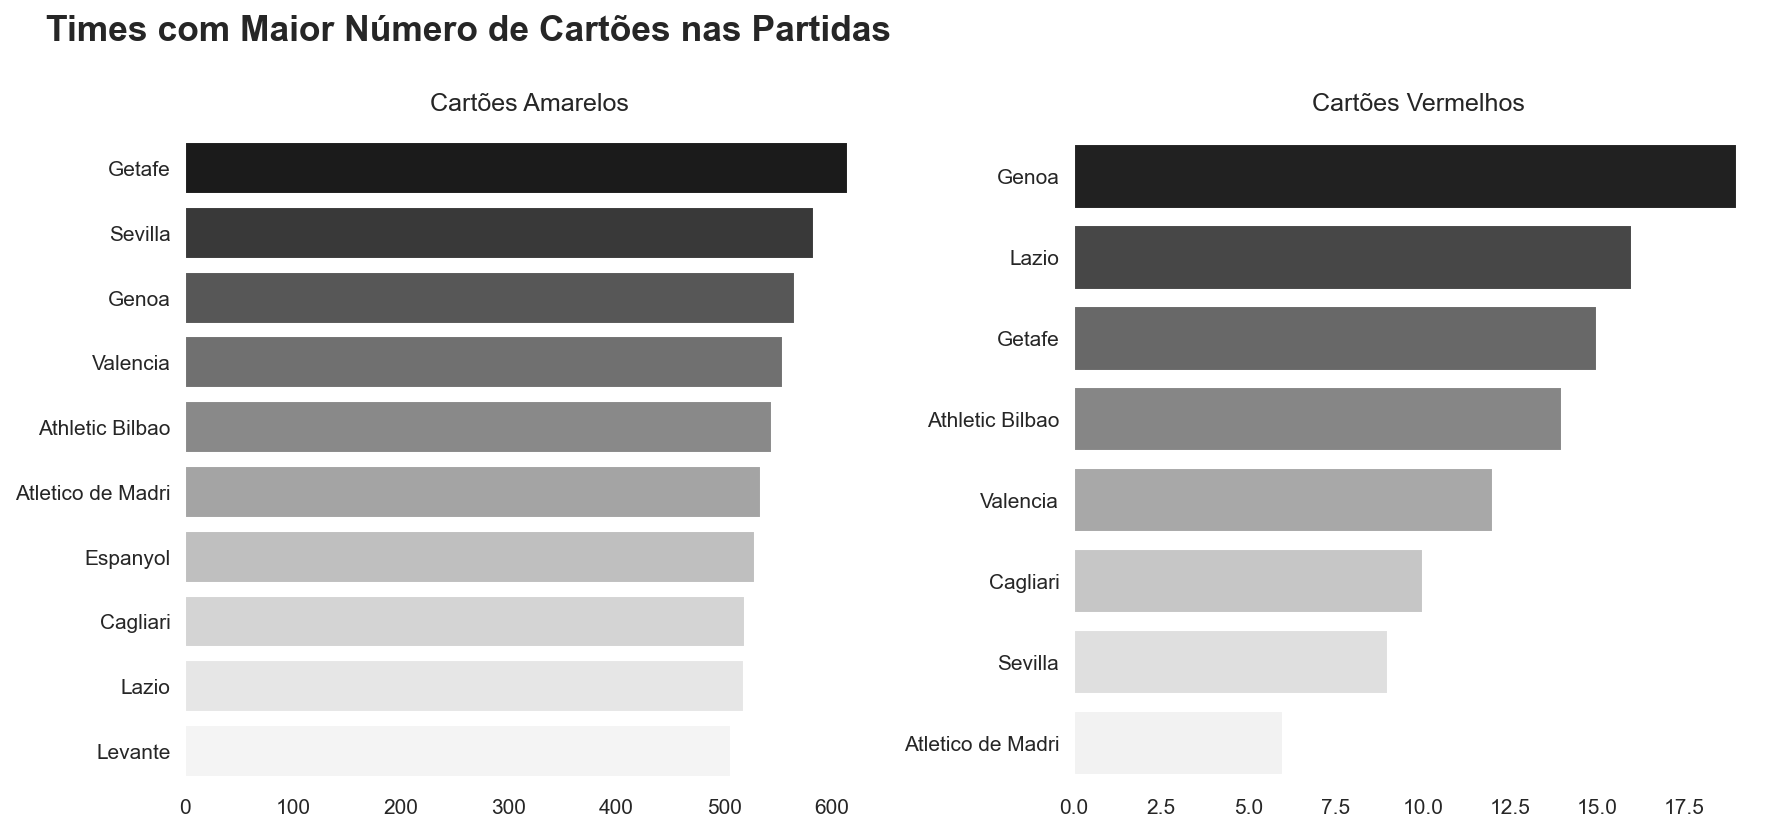

In [348]:
# Criando dataframe auxiliar agrupando os times e somando os seus diferentes tipos de cartões em diferentes colunas
lista_cartoes = ["Cartões amarelos 1", "Cartões vermelhos 1"]
aux = df.groupby("Time 1")[lista_cartoes].sum().reset_index()

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(12, 5.5))
axs = axs.flatten()

# Criando o gráfico de barplot impedindo duplicatas em número de cartão para deixar mais interessante e aplicando cosméticos para deixar o visual mais "clean"
for idx, nome in enumerate(lista_cartoes):
    aux = aux.drop_duplicates(subset=[nome]).sort_values(by = nome, ascending = False).head(10)
    sns.barplot(data=aux, x=nome, y="Time 1", hue = "Time 1", legend = False, ax=axs[idx], palette="Greys_r")
    
    # Estilização dos plots
    axs[idx].set_title(nome.rstrip("1").title(), y = 1.02)
    axs[idx].set_ylabel('')
    axs[idx].set_xlabel('')
    for spine in axs[idx].spines.values():spine.set_visible(False)

fig.suptitle('Times com Maior Número de Cartões nas Partidas', x = 0.03, ha = "left", fontsize=17, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

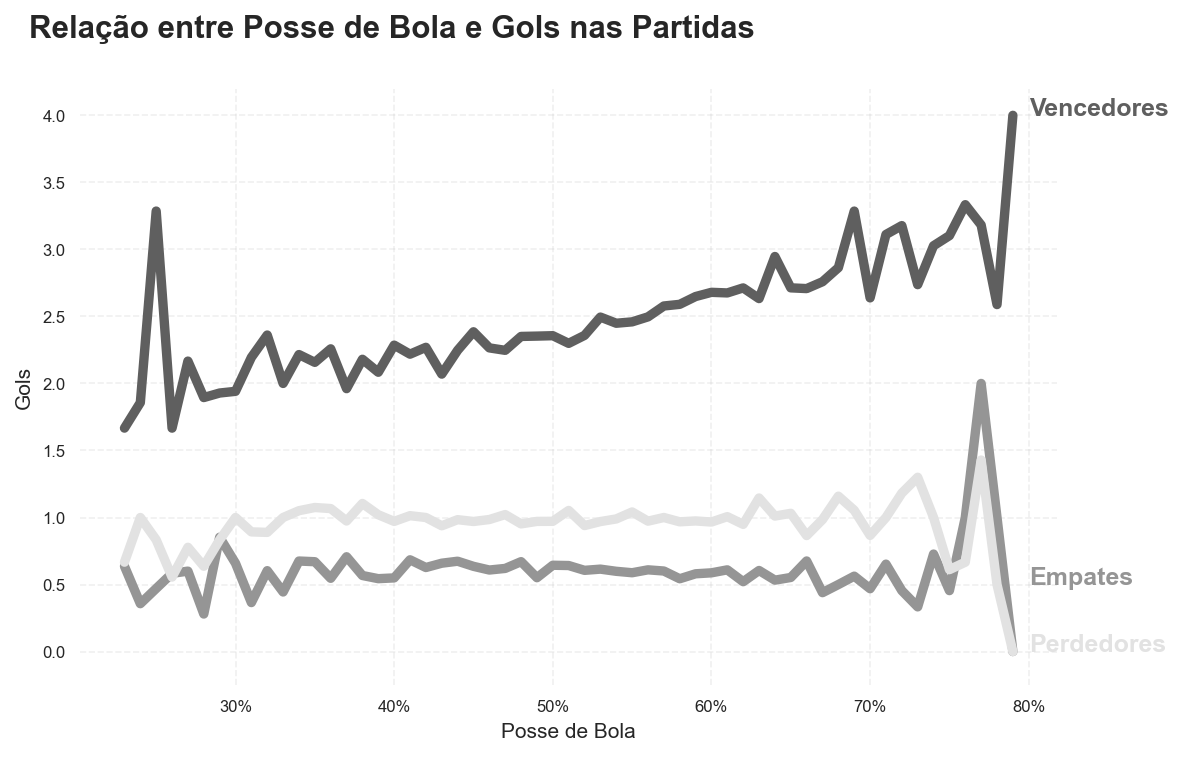

In [349]:
# Dataframe auxiliar que limita o escopo da posse de bola
aux = df[(df["Posse 1(%)"] > 22.0) & (df["Posse 1(%)"] < 80.0)]

# Criação de três lineplots para os times vencedores, perdedores e empates.
fig = plt.figure(figsize = (8,5), dpi = 150)
sns.lineplot(data = aux[aux['Time 1'] == aux["Vencedor"]], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.7), errorbar=None)
plt.text(80, 4, "Vencedores", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.7))
sns.lineplot(data = aux[(aux['Time 2'] == aux["Vencedor"])], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.5), errorbar=None)
plt.text(80, 0.5, "Empates", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.5))
sns.lineplot(data = aux[(aux["Vencedor"] == "Empate")], x="Posse 1(%)", y="Gols 1", linewidth = 4.5, color=plt.cm.Greys(0.2), errorbar=None)
plt.text(80, 0, "Perdedores", fontsize=12, fontfamily='sans-serif', fontweight='bold', color = plt.get_cmap('Greys')(0.2))

# Estilização do gráfico
ax = plt.gca()
for spine in ax.spines.values():spine.set_visible(False)
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_ylim(-0.25, 4.2)
ax.set_xlabel("Posse de Bola")
ax.set_ylabel("Gols")
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.tick_params(axis='both', which='major', labelsize=8)

fig.suptitle('Relação entre Posse de Bola e Gols nas Partidas', x = 0.03, ha = "left", fontsize=15, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

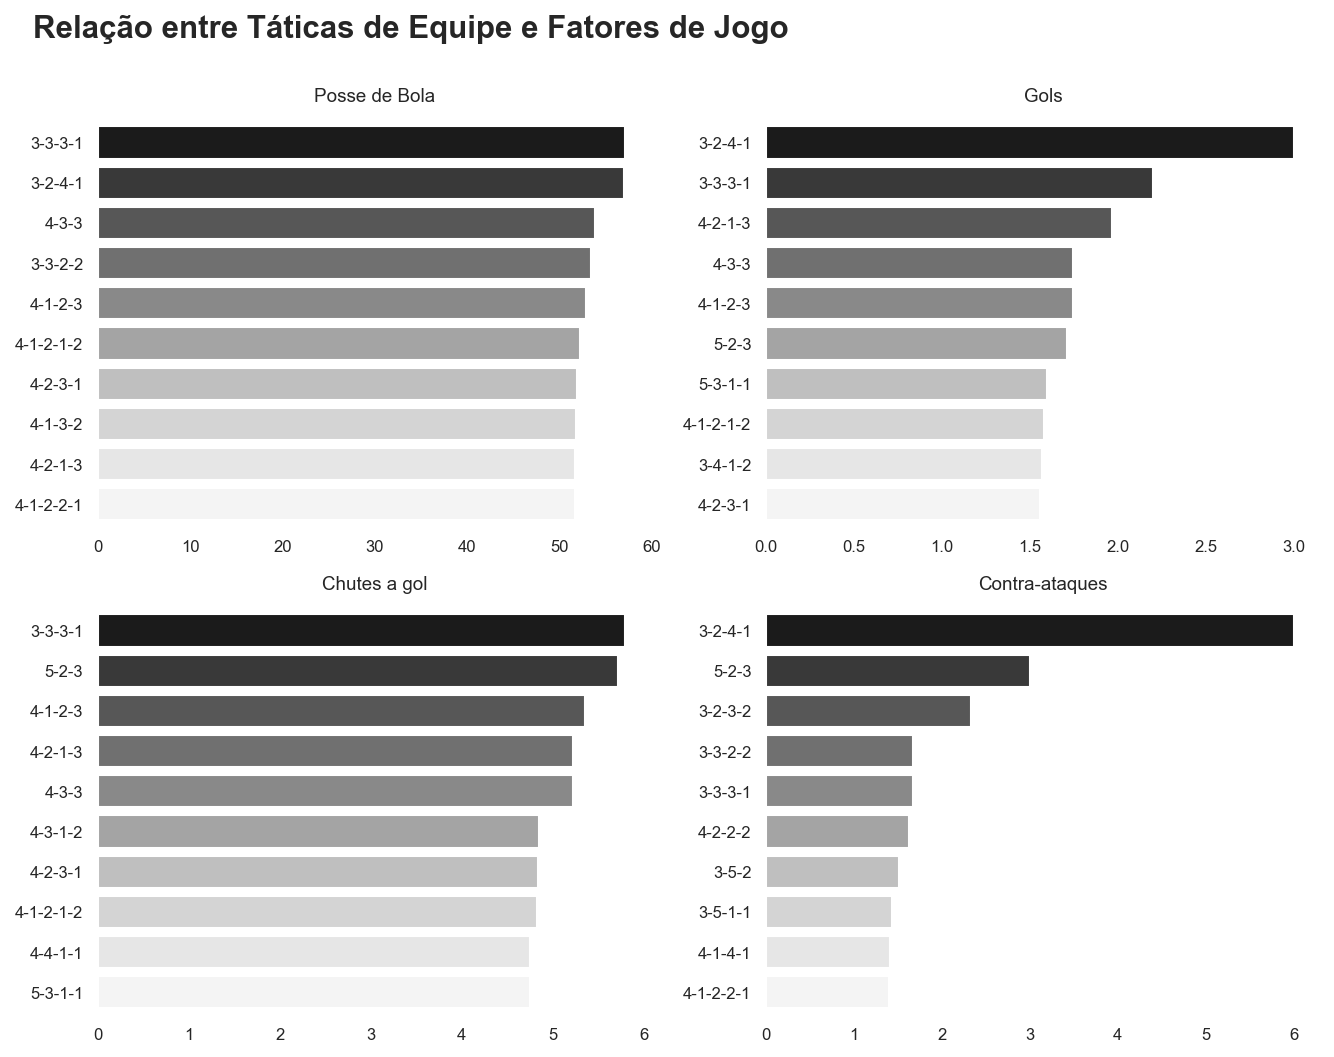

In [350]:
# Lista com as colunas interessantes e titulos à serem usados
lista_elementos = ["Posse 1(%)", "Gols 1", "Chutes a gol 1", "Contra-ataques 1"]
lista_titulos = ["Posse de Bola", "Gols", "Chutes a gol", "Contra-ataques"]
fig, axs = plt.subplots(2, 2, figsize=(9, 7), dpi=150)
axs = axs.flatten()

# Criação dos 4 gráficos de barras
for idx, nome in enumerate(lista_elementos):
    aux = df.groupby("Position 1")[nome].mean().reset_index().sort_values(by=nome, ascending=False)
    bar_plot = sns.barplot(data=aux.head(10), x=nome, y="Position 1", ax=axs[idx], hue = "Position 1", palette = "Greys_r")
    
    # Estilização dos plots
    for spine in axs[idx].spines.values():spine.set_visible(False)
    axs[idx].set_ylabel("")
    axs[idx].set_xlabel("")
    axs[idx].tick_params(axis='both', labelsize=8)
    axs[idx].set_title(lista_titulos[idx], y = 1.02, fontsize = 9)

fig.suptitle('Relação entre Táticas de Equipe e Fatores de Jogo', x = 0.03, ha = "left", fontsize=15, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

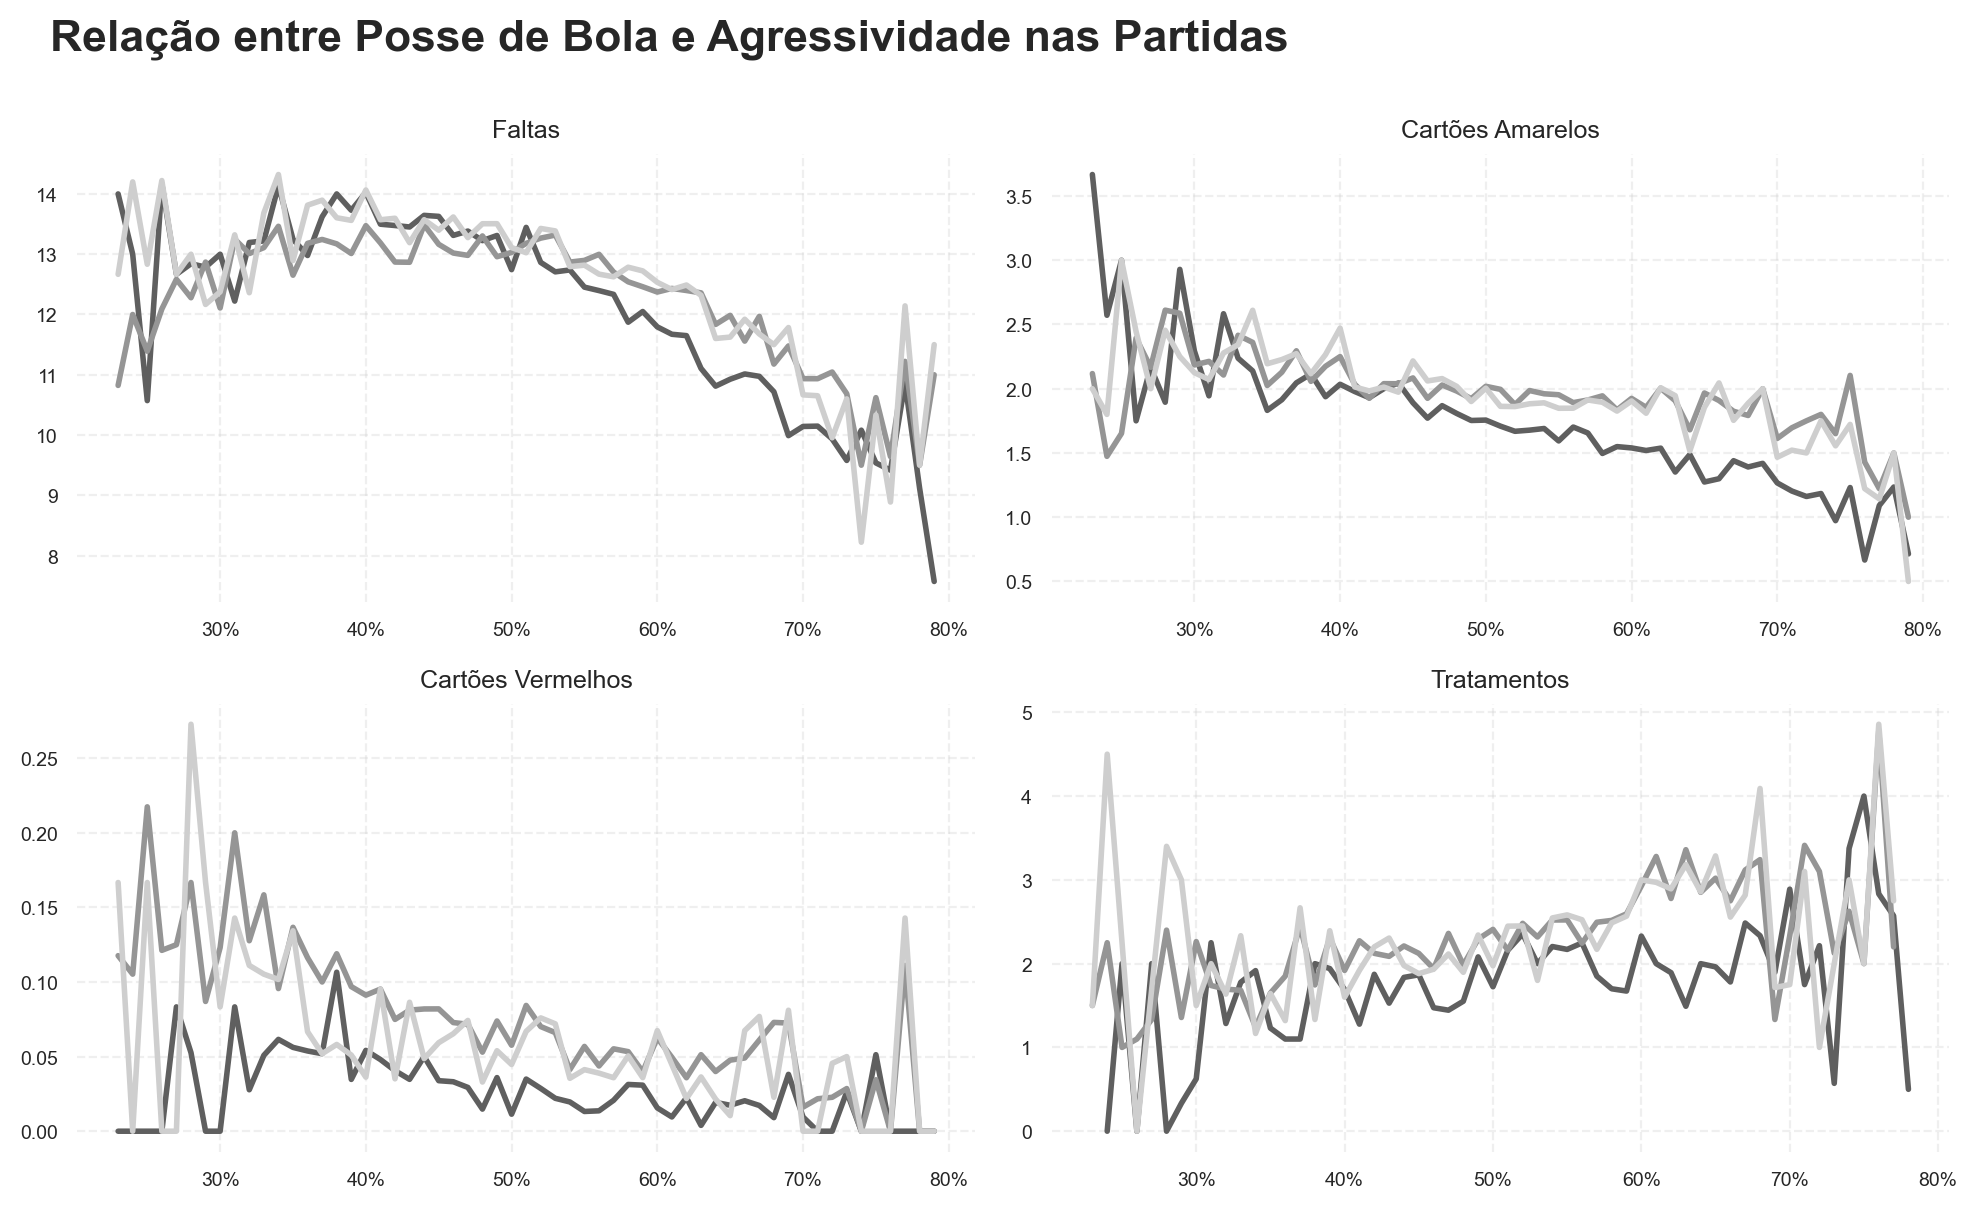

In [351]:
aux = df[(df["Posse 1(%)"] > 22.0) & (df["Posse 1(%)"] < 80.0)]
colunas_interesse = ["Faltas 1", "Cartões amarelos 1", "Cartões vermelhos 1", "Tratamentos 2"]
titulos = ["Faltas", "Cartões Amarelos", "Cartões Vermelhos", "Tratamentos"]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=200)
axs = axs.flatten()
# Loop para gerar os gráficos
for idx, coluna in enumerate(colunas_interesse):
    sns.lineplot(data=aux[aux["Time 1"] == aux["Vencedor"]], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.7), ax=axs[idx], errorbar=None)
    sns.lineplot(data=aux[aux["Time 1"] != aux["Vencedor"]], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.5), ax=axs[idx], errorbar=None)
    sns.lineplot(data=aux[aux["Vencedor"] == "Empate"], x="Posse 1(%)", y=coluna, linewidth=2, color=plt.cm.Greys(0.3), ax=axs[idx], errorbar=None)

    # Estilização dos plots
    for spine in axs[idx].spines.values(): spine.set_visible(False)
    axs[idx].grid(True, linestyle='--', alpha=0.3)
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")
    axs[idx].set_title(titulos[idx], fontsize = 9)
    axs[idx].xaxis.set_major_formatter(PercentFormatter(xmax=100))
    axs[idx].tick_params(axis='both', labelsize=7)
    
fig.suptitle('Relação entre Posse de Bola e Agressividade nas Partidas', x=0.03, ha="left", fontsize=16, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

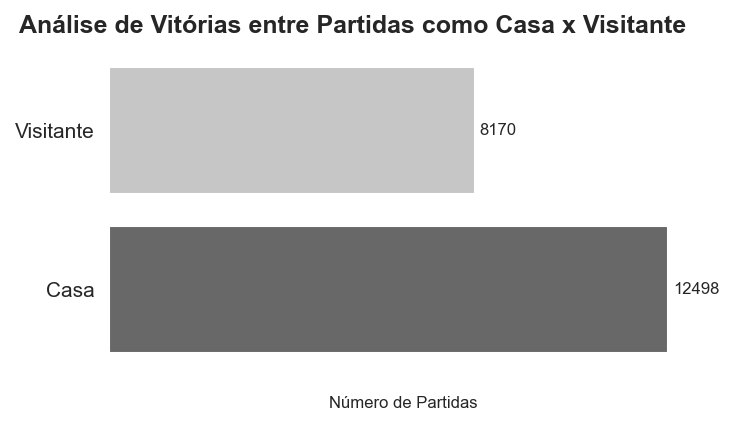

In [352]:
# Lógica para criar as colunas necessárias
aux = df.groupby("Vencedor")["Vitória em Casa"].value_counts().reset_index() 
aux.columns = ["Vencedor", "Vitória em Casa", "Contagem"]
aux1 = aux.groupby("Vitória em Casa")["Contagem"].sum().reset_index()
aux1.columns = ["Vitória em Casa", "Contagem"]
aux1 = aux1.replace({1 : "Casa", 0 : "Visitante"})

# Lógica do gráfico
fig, ax = plt.subplots(figsize=(5, 3), dpi = 150)
bar_plot = sns.barplot(y="Vitória em Casa", x="Contagem", hue = "Vitória em Casa", data=aux1, palette="Greys", ax=ax)
ax.set_xlabel("Número de Partidas", fontsize = 8, labelpad = 13)
ax.set_ylabel("")
ax.set_xticks([])
ax.tick_params(axis='x', labelsize=7, length=-10)
for spines in ax.spines.values(): spines.set_visible(False)

# Anotações ao lado das barras 
for p in bar_plot.patches:
    ax.annotate(f'{int(p.get_width())}',(p.get_width() + 111, p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=8)

fig.suptitle('Análise de Vitórias entre Partidas como Casa x Visitante', x=0.036, ha="left", fontsize=12, fontweight='bold', y=0.93)
plt.tight_layout()
plt.show()

# Tratamento de Dados

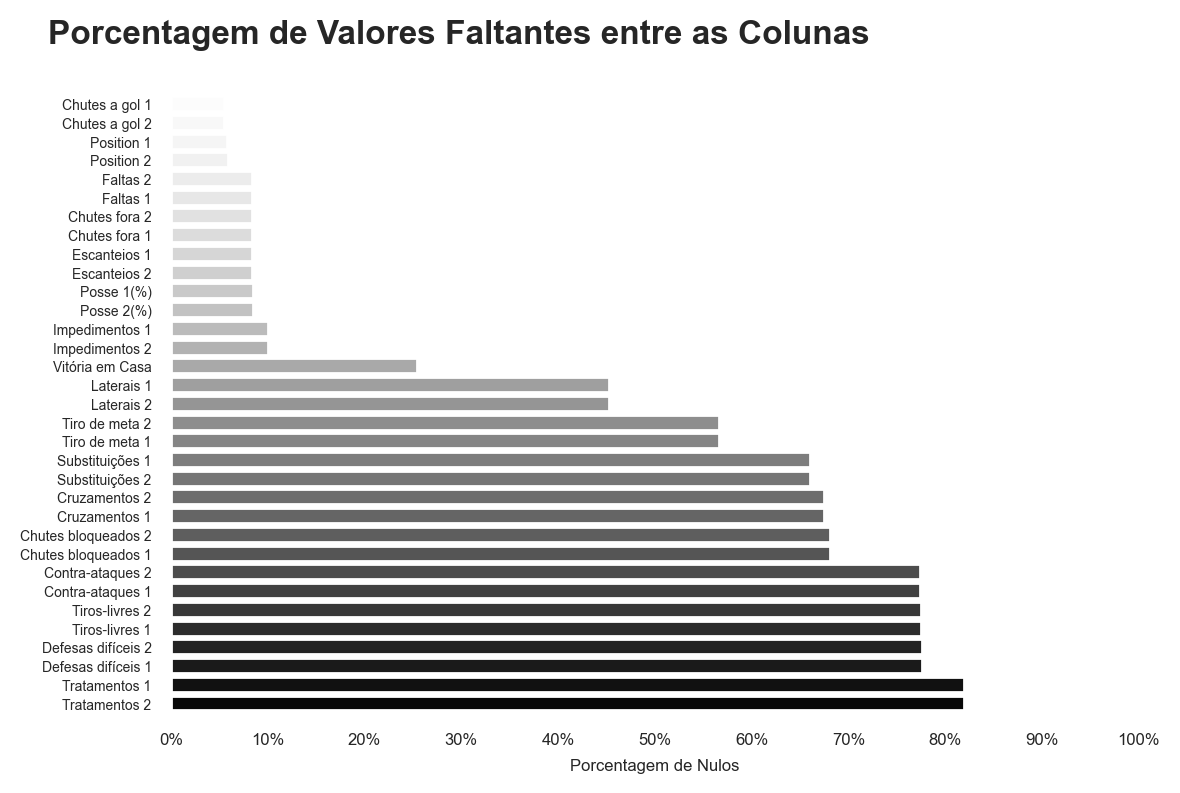

In [353]:
# Função que retorna um dataframe contendo os valores faltantes de cada coluna
def porcentam_faltantes(df):
    sorted_sum = df.isna().sum().sort_values(ascending=True) / len(df)
    sorted_sum = sorted_sum[sorted_sum > 0]  
    return sorted_sum

# Função que retorna um barplot já estilizado com a porcentagem de colunas faltando
def gerador_de_missplot(df):
    missing_values = porcentam_faltantes(df)
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
    sns.barplot(y=missing_values.index, x=missing_values.values, hue=missing_values.index, palette="Greys", ax=ax, orient="h")

    ax.set_xticks([i / 10 for i in range(0, 11)])
    ax.tick_params(axis='y', labelsize=5)
    ax.tick_params(axis='x', labelsize=6)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.set_ylabel("")
    ax.set_xlabel("Porcentagem de Nulos", fontsize=6)
    ax.grid(False)
    for spine in ax.spines.values(): spine.set_visible(False)

    fig.suptitle('Porcentagem de Valores Faltantes entre as Colunas', x=0.048, ha="left", fontsize=12, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
gerador_de_missplot(df)

In [354]:
# Eliminar colunas acima de 60%
aux = porcentam_faltantes(df)
aux = aux.reset_index()
aux.columns = ["Coluna", "Porcentagem"]

# Eliminando colunas com mais de 60% de valores faltantes, e criando um novo dataframe
new_df = df
for coluna in aux[aux["Porcentagem"] >= 0.6]["Coluna"]:
    new_df = new_df.drop(coluna, axis=1)

In [355]:
lista_elementos = []

for idx, coluna in enumerate(new_df.select_dtypes(exclude = 'object').columns): 
    if idx % 2 == 0:
        # Média de laterais totais por partida
        total_laterais = abs(new_df[coluna] + new_df[coluna.replace("1","2")])
        laterais_media = total_laterais.mean()
        print(f"Coluna: {coluna.replace('1','')} || média: {round(laterais_media)}")
    
        # Média da diferença das laterais entre times por partidas
        diff_laterais = abs(new_df[coluna] - new_df[coluna.replace("1","2")])
        diff_laterais_media = diff_laterais.mean()
        print(f"Coluna: {coluna.replace('1','')} || diferença média: {round(diff_laterais_media)}")
    
        lista_elementos.append([coluna.replace(" 1",""), round(laterais_media), round(diff_laterais_media)])

Coluna: Chutes a gol  || média: 9
Coluna: Chutes a gol  || diferença média: 3
Coluna: Impedimentos  || média: 4
Coluna: Impedimentos  || diferença média: 2
Coluna: Escanteios  || média: 10
Coluna: Escanteios  || diferença média: 4
Coluna: Chutes fora  || média: 11
Coluna: Chutes fora  || diferença média: 3
Coluna: Faltas  || média: 26
Coluna: Faltas  || diferença média: 4
Coluna: Cartões amarelos  || média: 4
Coluna: Cartões amarelos  || diferença média: 1
Coluna: Cartões vermelhos  || média: 0
Coluna: Cartões vermelhos  || diferença média: 0
Coluna: Laterais  || média: 31
Coluna: Laterais  || diferença média: 5
Coluna: Gols  || média: 3
Coluna: Gols  || diferença média: 1
Coluna: Tiro de meta  || média: 15
Coluna: Tiro de meta  || diferença média: 4
Coluna: Posse (%) || média: 100
Coluna: Posse (%) || diferença média: 15
Coluna: Vitória em Casa || média: 1
Coluna: Vitória em Casa || diferença média: 0


In [356]:
#for coluna in aux[aux["Porcentagem"] < 0.6]["Coluna"]:
 #   new_df[coluna] = new_df[coluna].fillna()

In [357]:
for coluna in df.select_dtypes(exclude = ['object']).columns:
    bool = ((df[coluna] == 0).any()) and ((df[coluna].isna())).any()
    print(f"Coluna {coluna}: {bool}")

Coluna Chutes a gol 1: True
Coluna Chutes a gol 2: True
Coluna Impedimentos 1: True
Coluna Impedimentos 2: True
Coluna Escanteios 1: True
Coluna Escanteios 2: True
Coluna Chutes fora 1: True
Coluna Chutes fora 2: True
Coluna Faltas 1: True
Coluna Faltas 2: True
Coluna Cartões amarelos 1: False
Coluna Cartões amarelos 2: False
Coluna Cartões vermelhos 1: False
Coluna Cartões vermelhos 2: False
Coluna Cruzamentos 1: True
Coluna Cruzamentos 2: True
Coluna Laterais 1: True
Coluna Laterais 2: True
Coluna Chutes bloqueados 1: True
Coluna Chutes bloqueados 2: True
Coluna Contra-ataques 1: True
Coluna Contra-ataques 2: True
Coluna Gols 1: False
Coluna Gols 2: False
Coluna Tiro de meta 1: True
Coluna Tiro de meta 2: True
Coluna Tratamentos 1: True
Coluna Tratamentos 2: True
Coluna Substituições 1: True
Coluna Substituições 2: True
Coluna Tiros-livres 1: False
Coluna Tiros-livres 2: True
Coluna Defesas difíceis 1: True
Coluna Defesas difíceis 2: True
Coluna Posse 1(%): True
Coluna Posse 2(%): Tr

In [358]:
def removedor_outliers(df, col, fator):
    # Esse fillna deve ser REMOVIDO após concluir-se a fase de imputação de valores faltantes
    df.loc[:, col] = df[col].fillna(df[col].mean())
    q25, q75 = np.percentile(df[col], [25, 75])
    iqr = q75 - q25
    limite_inferior = q25 - fator * iqr
    limite_superior = q75 + fator * iqr
    df_filtrado = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]
    print(f"{col}: {len(df) - len(df_filtrado)} outliers removidos.")
    return df_filtrado

    
for coluna in ["Chutes a gol 1", "Chutes a gol 2", "Chutes fora 2", "Faltas 1", "Faltas 2", "Posse 1(%)"]:
    df = removedor_outliers(df, coluna, fator=1.5) 

Chutes a gol 1: 886 outliers removidos.
Chutes a gol 2: 572 outliers removidos.
Chutes fora 2: 1003 outliers removidos.
Faltas 1: 570 outliers removidos.
Faltas 2: 584 outliers removidos.
Posse 1(%): 461 outliers removidos.


# Rascunho